# Social Relations Model (SRM) Analysis
## Section 2.1 from Hoff (2018)

This notebook implements the ANOVA-style Social Relations Model for the IR90s export data.

In [2]:
import sys
sys.path.append('../')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from variables import *

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 5)

## 1. Load and Prepare Data

Following the intro notebook, we filter to 7 countries and focus on export data.

In [ ]:
# Load data
node_df = pd.read_csv('../' + DATA_FOLDER + NODE_VARS)
dyad_df = pd.read_csv('../' + DATA_FOLDER + DYAD_VARS)

# Countries of interest (from intro notebook)
COUNTRIES = sorted(['USA', 'JPN', 'CHN', 'ITA', 'NTH', 'DEN', 'FRN'])
#COUNTRIES = dyad_df.iloc[:, 0].tolist()


# Filter to export columns for these countries
export_cols = [f'{c}.exports' for c in COUNTRIES]
dyad_df_filtered = dyad_df[export_cols].copy()

print(f"Dataset shape: {dyad_df_filtered.shape}")
print(f"Countries: {len(COUNTRIES)}")

Dataset shape: (130, 130)
Countries: 130


## 2. Construct the Sociomatrix

Create an n×n sociomatrix Y where y_i,j is the export volume from country i to country j (in log billions of dollars).

The paper states: "yi,j is the 1990 export volume from country i to country j, in log billions of dollars."

In [4]:
# The columns represent exports TO each country (imports by that country)
# Rows represent exporting countries
# We need to reshape this into a proper sociomatrix

# First, let's identify which countries are represented in the rows
# by looking at the country index
dyad_df_with_index = pd.read_csv('../' + DATA_FOLDER + DYAD_VARS)
country_codes = dyad_df_with_index.iloc[:, 0].values  # First column contains country codes

# Find indices of our 7 countries
country_indices = {}
for i, code in enumerate(country_codes):
    if code in COUNTRIES:
        country_indices[code] = i

# Extract the 7x7 sociomatrix
n = len(COUNTRIES)
Y = np.zeros((n, n))

for i, sender in enumerate(COUNTRIES):
    if sender in country_indices:
        row_idx = country_indices[sender]
        for j, receiver in enumerate(COUNTRIES):
            col_name = f'{receiver}.exports'
            # This is exports TO receiver (imports by receiver)
            # From sender at row_idx
            Y[i, j] = dyad_df_with_index.iloc[row_idx][col_name]

# Convert to log scale (add small constant to handle zeros)
Y_log = np.log(Y + 0.01)

# Create DataFrame for better visualization
Y_df = pd.DataFrame(Y_log, index=COUNTRIES, columns=COUNTRIES)
print("\nSociomatrix Y (log billions of dollars):")
print(Y_df.round(2))


Sociomatrix Y (log billions of dollars):
      AFG   ALB   ALG   ANG   ARG   AUL   AUS   BAH   BEL   BEN  ...   TUR  \
AFG   NaN -4.61 -4.61 -4.61 -4.61 -4.61 -4.61 -4.61 -3.51 -4.61  ... -4.61   
ALB -4.61   NaN -4.61 -4.61 -4.61 -4.61 -4.61 -4.61 -4.61 -4.61  ... -4.61   
ALG -4.61 -4.61   NaN -4.61 -3.91 -4.61 -1.47 -4.61 -0.67 -4.61  ... -0.78   
ANG -4.61 -4.61 -3.91   NaN -3.91 -4.61 -4.61 -4.61 -1.27 -4.61  ... -4.61   
ARG -4.61 -4.61 -2.66 -3.51   NaN -2.66 -3.51 -3.91 -1.24 -4.61  ... -1.90   
..    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
USA -3.91 -3.51 -0.02 -1.35  1.41  2.47  0.98 -0.82  2.14 -3.22  ...  1.17   
VEN -4.61 -4.61 -4.61 -4.61 -2.81 -4.61 -4.61 -4.61 -1.90 -4.61  ... -3.91   
YEM -4.61 -4.61 -4.61 -4.61 -3.91 -3.51 -3.22 -3.91 -4.61 -4.61  ... -3.51   
ZAM -4.61 -4.61 -4.61 -4.61 -4.61 -4.61 -4.61 -4.61 -2.66 -4.61  ... -4.61   
ZIM -4.61 -4.61 -4.61 -3.91 -4.61 -3.91 -3.91 -4.61 -3.22 -4.61  ... -3.91   

      UAE   UGA   UKG

## 3. ANOVA Decomposition

Following Section 2.1, we decompose Y as:
$$y_{i,j} = \mu + a_i + b_j + \epsilon_{i,j}$$

Where:
- $\mu$ = grand mean
- $a_i$ = row effect (sender effect) = row mean - grand mean
- $b_j$ = column effect (receiver effect) = column mean - grand mean
- $\epsilon_{i,j}$ = residual

In [5]:
# Calculate grand mean (excluding diagonal)
# Note: diagonal is undefined in sociomatrices
mask = ~np.eye(n, dtype=bool)
mu = np.mean(Y_log[mask])

# Calculate row effects (sender effects)
# a_i = mean of row i (excluding diagonal) - mu
a = np.array([np.mean(Y_log[i, mask[i]]) for i in range(n)]) - mu

# Calculate column effects (receiver effects)
# b_j = mean of column j (excluding diagonal) - mu
b = np.array([np.mean(Y_log[mask[:, j], j]) for j in range(n)]) - mu

# Calculate residuals
E = Y_log - (mu + a[:, np.newaxis] + b[np.newaxis, :])

# Display results
effects_df = pd.DataFrame({
    'Country': COUNTRIES,
    'Row Effect (a_i)': a,
    'Column Effect (b_i)': b
})
print("*"*60)
print("# Results of additive effects model:")
print(f"\nGrand Mean (μ): {mu:.3f}")
print("\nNode Effects:")
print(effects_df.round(3))
print("*"*60)

************************************************************
# Results of additive effects model:

Grand Mean (μ): -3.878

Node Effects:
    Country  Row Effect (a_i)  Column Effect (b_i)
0       AFG            -0.664               -0.600
1       ALB            -0.662               -0.570
2       ALG            -0.016                0.037
3       ANG            -0.371               -0.370
4       ARG             0.622                0.373
..      ...               ...                  ...
125     USA             2.883                2.936
126     VEN             0.089                0.008
127     YEM            -0.339               -0.248
128     ZAM            -0.427               -0.525
129     ZIM            -0.288               -0.391

[130 rows x 3 columns]
************************************************************


## 4. Estimate Variance Components

The Social Relations Model includes:
- $\sigma^2_a$ = variance of row effects
- $\sigma^2_b$ = variance of column effects
- $\sigma_{ab}$ = covariance between row and column effects
- $\sigma^2$ = residual variance
- $\rho$ = dyadic correlation (correlation between $\epsilon_{i,j}$ and $\epsilon_{j,i}$)

In [6]:
# Variance of row effects
sigma2_a = np.var(a, ddof=1)

# Variance of column effects
sigma2_b = np.var(b, ddof=1)

# Covariance between row and column effects
sigma_ab = np.cov(a, b)[0, 1]

# Residual variance (from off-diagonal elements)
epsilon_vals = E[mask]
sigma2 = np.var(epsilon_vals, ddof=1)

# Dyadic correlation
# For each dyad (i,j) with i<j, compute correlation between e_ij and e_ji
epsilon_ij = []
epsilon_ji = []
for i in range(n):
    for j in range(i+1, n):
        epsilon_ij.append(E[i, j])
        epsilon_ji.append(E[j, i])

rho = np.corrcoef(epsilon_ij, epsilon_ji)[0, 1]

print("\nVariance Components:")
print(f"σ²_a (row variance):        {sigma2_a:.4f}")
print(f"σ²_b (column variance):     {sigma2_b:.4f}")
print(f"σ_ab (row-col covariance):  {sigma_ab:.4f}")
print(f"σ² (residual variance):     {sigma2:.4f}")
print(f"ρ (dyadic correlation):     {rho:.4f}")

# Total variance
total_var = sigma2_a + 2*sigma_ab + sigma2_b + sigma2
print(f"\nTotal variance:             {total_var:.4f}")
print(f"\nVariance decomposition:")
print(f"  Row effects:     {100*sigma2_a/total_var:.1f}%")
print(f"  Column effects:  {100*sigma2_b/total_var:.1f}%")
print(f"  Row-col cov:     {100*2*sigma_ab/total_var:.1f}%")
print(f"  Residual:        {100*sigma2/total_var:.1f}%")


Variance Components:
σ²_a (row variance):        0.6228
σ²_b (column variance):     0.5260
σ_ab (row-col covariance):  0.5629
σ² (residual variance):     0.7069
ρ (dyadic correlation):     0.7926

Total variance:             2.9817

Variance decomposition:
  Row effects:     20.9%
  Column effects:  17.6%
  Row-col cov:     37.8%
  Residual:        23.7%


## 5. Visualizations (Figure 1 from Paper)

Recreate Figure 1: Left panel shows row effects vs column effects, right panel shows dyadic residual correlation.

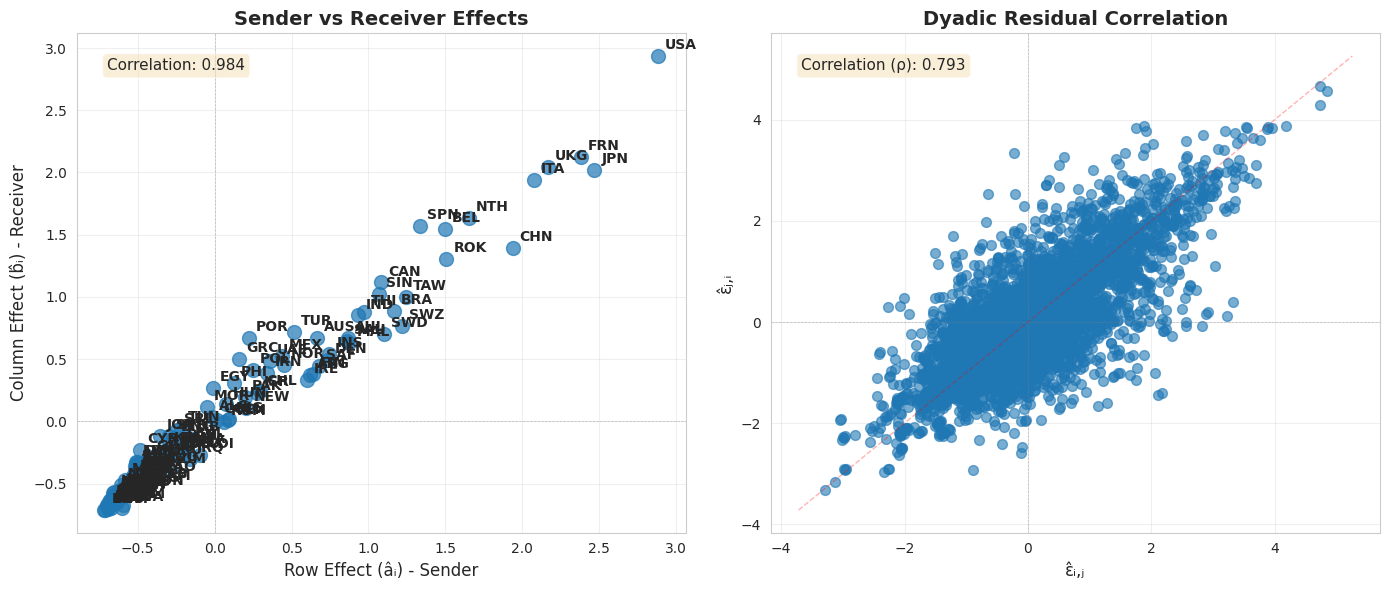


Figure saved as 'srm_analysis_figure1.png'


In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left panel: Row effects vs Column effects
ax1 = axes[0]
ax1.scatter(a, b, s=100, alpha=0.7)
for i, country in enumerate(COUNTRIES):
    ax1.annotate(country, (a[i], b[i]), 
                xytext=(5, 5), textcoords='offset points',
                fontsize=10, fontweight='bold')

# Add reference lines
ax1.axhline(0, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
ax1.axvline(0, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

ax1.set_xlabel('Row Effect (âᵢ) - Sender', fontsize=12)
ax1.set_ylabel('Column Effect (b̂ᵢ) - Receiver', fontsize=12)
ax1.set_title('Sender vs Receiver Effects', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Add correlation text
corr_ab = np.corrcoef(a, b)[0, 1]
ax1.text(0.05, 0.95, f'Correlation: {corr_ab:.3f}',
         transform=ax1.transAxes, fontsize=11,
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Right panel: Dyadic residuals e_ij vs e_ji
ax2 = axes[1]
ax2.scatter(epsilon_ij, epsilon_ji, s=50, alpha=0.6)

# Add reference lines
ax2.axhline(0, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
ax2.axvline(0, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

# Add diagonal line
lims = [min(ax2.get_xlim()[0], ax2.get_ylim()[0]),
        max(ax2.get_xlim()[1], ax2.get_ylim()[1])]
ax2.plot(lims, lims, 'r--', alpha=0.3, linewidth=1)

ax2.set_xlabel('ε̂ᵢ,ⱼ', fontsize=12)
ax2.set_ylabel('ε̂ⱼ,ᵢ', fontsize=12)
ax2.set_title('Dyadic Residual Correlation', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Add correlation text
ax2.text(0.05, 0.95, f'Correlation (ρ): {rho:.3f}',
         transform=ax2.transAxes, fontsize=11,
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('srm_analysis_figure1.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nFigure saved as 'srm_analysis_figure1.png'")

## 6. Interpretation

From the paper (Section 2.1):

1. **Sender-Receiver Correlation**: A positive correlation between row and column effects indicates that countries with large export volumes typically have large import volumes as well.

2. **Dyadic Correlation (ρ)**: A positive dyadic correlation indicates reciprocity - if country i exports more to country j than expected, then country j tends to export more to country i than expected.

3. **Model Adequacy**: The SRM accounts for row/column heterogeneity and dyadic correlation, but cannot capture third-order dependencies like transitivity (which requires the multiplicative effects in Section 3).

In [8]:
# Summary interpretation
print("INTERPRETATION:")
print("="*60)
print(f"\n1. Sender-Receiver Correlation: {corr_ab:.3f}")
if corr_ab > 0.5:
    print("   → Strong positive correlation: Countries that export more")
    print("     also tend to import more (typical of large economies)")
elif corr_ab > 0:
    print("   → Positive correlation: Some tendency for exporters")
    print("     to also be importers")
else:
    print("   → Negative or no correlation")

print(f"\n2. Dyadic Correlation (ρ): {rho:.3f}")
if rho > 0.5:
    print("   → Strong reciprocity: Bilateral trade is highly mutual")
elif rho > 0:
    print("   → Moderate reciprocity: Some tendency for mutual trade")
else:
    print("   → Weak or no reciprocity in trade")

print(f"\n3. Variance Decomposition:")
print(f"   → Node heterogeneity (row+col): {100*(sigma2_a+sigma2_b)/total_var:.1f}%")
print(f"   → Residual variation: {100*sigma2/total_var:.1f}%")
print("\n" + "="*60)

INTERPRETATION:

1. Sender-Receiver Correlation: 0.984
   → Strong positive correlation: Countries that export more
     also tend to import more (typical of large economies)

2. Dyadic Correlation (ρ): 0.793
   → Strong reciprocity: Bilateral trade is highly mutual

3. Variance Decomposition:
   → Node heterogeneity (row+col): 38.5%
   → Residual variation: 23.7%



## 7. Social Relations Regression Model (SRRM) - Section 2.2

Now we extend the SRM by adding covariates. Following section 2.2 of Hoff (2018), we model:

$$y_{i,j} = \beta^T \mathbf{x}_{i,j} + a_i + b_j + \epsilon_{i,j}$$

Where:
- $\mathbf{x}_{i,j}$ is a vector of covariates (can include sender, receiver, and dyadic covariates)
- $\beta$ is a vector of regression coefficients

For the IR90s trade data, we include:
- **Sender (row) covariates**: Exporter's GDP and polity score
- **Receiver (column) covariates**: Importer's GDP and polity score  
- **Dyadic covariates**: Geographic distance between country capitals

In [9]:
# Import the updated SRM module
#import sys
#sys.path.append('../src')
from src.srm import SocialRelationsModel, load_ir90s_data

# Load data with covariates for a subset of 30 countries (as in the paper)
countries_30 = ['USA', 'JPN', 'CHN', 'ITA', 'NTH', 'DEN', 'FRN',
                'ARG', 'AUL', 'BEL', 'BNG', 'BRA', 'CAN', 'COL', 'EGY',
                'IND', 'INS', 'IRN', 'MEX', 'PAK', 'PHI', 'POL', 'ROK',
                'SAF', 'SAU', 'SPN', 'SWD', 'TAW', 'THI', 'TUR']

print(f"Loading trade data with covariates for {len(countries_30)} countries...")
Y_srrm, countries_srrm, covariates = load_ir90s_data('../data', 
                                                      countries=countries_30,
                                                      load_covariates=True)

print(f"\nLoaded sociomatrix: {Y_srrm.shape}")
print(f"Number of countries: {len(countries_srrm)}")
print(f"\nCovariates loaded:")
print(f"  - Row (sender) covariates: {covariates['row'].shape} ({covariates['names']['row']})")
print(f"  - Column (receiver) covariates: {covariates['col'].shape} ({covariates['names']['col']})")
print(f"  - Dyadic covariates: {covariates['dyad'].shape} ({covariates['names']['dyad']})")

Loading trade data with covariates for 30 countries...

Loaded sociomatrix: (30, 30)
Number of countries: 30

Covariates loaded:
  - Row (sender) covariates: (30, 2) (['GDP', 'Polity'])
  - Column (receiver) covariates: (30, 2) (['GDP', 'Polity'])
  - Dyadic covariates: (30, 30) (['Distance'])


In [10]:
# Fit the SRRM
print("Fitting Social Relations Regression Model...")
print("="*60)

srrm = SocialRelationsModel(Y_srrm, X=covariates, node_names=countries_srrm)
srrm.fit()

print("\n✓ Model fitted successfully!")
print("\nModel Summary (including regression coefficients):")
print("="*60)
summary = srrm.summary()
print(summary.to_string(index=False))

print("\n" + "="*60)
print("\nInterpretation of Regression Coefficients:")
print("="*60)
beta = srrm.beta
print(f"\nβ_row_1 (Exporter GDP):  {beta[0]:.6f}")
print(f"β_row_2 (Exporter Polity): {beta[1]:.6f}")
print(f"β_col_1 (Importer GDP):  {beta[2]:.6f}")
print(f"β_col_2 (Importer Polity): {beta[3]:.6f}")
print(f"β_dyad_1 (Distance):      {beta[4]:.6f}")

print("\n→ Positive coefficients on GDP suggest that trade increases with economic size")
print("→ Negative coefficient on distance confirms gravity model prediction")
print("→ After controlling for these covariates, row/column effects capture")
print("  additional heterogeneity not explained by GDP, polity, or distance")

Fitting Social Relations Regression Model...

✓ Model fitted successfully!

Model Summary (including regression coefficients):
                Component     Value  % of Total Var
                  β_row_1  0.000554             NaN
                  β_row_2  0.034989             NaN
                  β_col_1  0.000516             NaN
                  β_col_2  0.041193             NaN
                 β_dyad_1 -1.144679             NaN
      Row Variance (σ²_a)  0.817134       28.593215
   Column Variance (σ²_b)  0.484875       16.966799
Row-Col Covariance (σ_ab)  0.576947       40.377148
   Residual Variance (σ²)  0.401886       14.062838
   Dyadic Correlation (ρ)  0.351803             NaN


Interpretation of Regression Coefficients:

β_row_1 (Exporter GDP):  0.000554
β_row_2 (Exporter Polity): 0.034989
β_col_1 (Importer GDP):  0.000516
β_col_2 (Importer Polity): 0.041193
β_dyad_1 (Distance):      -1.144679

→ Positive coefficients on GDP suggest that trade increases with economic size

In [11]:
# Display node effects after controlling for covariates
print("Node Effects (after controlling for GDP, polity, and distance):")
print("="*60)
effects_srrm = srrm.get_effects()
print(effects_srrm.to_string(index=False))

print("\n" + "="*60)
print("\nComparison: SRM vs SRRM Variance Components")
print("="*60)

# Compare variance decomposition
print("\nAfter adding covariates:")
print(f"  Row effect variance:     {srrm.sigma2_a:.4f}")
print(f"  Column effect variance:  {srrm.sigma2_b:.4f}")
print(f"  Row-col covariance:      {srrm.sigma_ab:.4f}")
print(f"  Residual variance:       {srrm.sigma2:.4f}")
print(f"  Dyadic correlation (ρ):  {srrm.rho:.4f}")

print("\n→ The covariates explain some of the variation, but substantial")
print("  heterogeneity remains in the additive effects (a_i, b_j)")
print("→ This suggests additional factors beyond GDP, polity, and distance")
print("  drive international trade patterns")

Node Effects (after controlling for GDP, polity, and distance):
Node  Row Effect (a_i)  Column Effect (b_i)
 USA         -0.801047            -0.513643
 JPN          1.092567             0.755724
 CHN          0.449488             0.250954
 ITA          0.826217             0.797895
 NTH          0.702098             0.944885
 DEN         -0.390962            -0.594489
 FRN          0.937158             0.906769
 ARG          0.228675            -0.203095
 AUL          0.935379             0.530513
 BEL          0.574009             0.553054
 BNG         -1.886106            -1.506392
 BRA          0.624794             0.203102
 CAN          0.590174             0.580886
 COL         -1.296840            -1.000481
 EGY         -1.530449            -0.528290
 IND         -0.821009            -1.013605
 INS          0.720471             0.379489
 IRN         -0.346204            -0.361030
 MEX         -0.240718             0.228995
 PAK         -1.178104            -1.088215
 PHI        

## 8. Summary and Connection to Hoff (2018)

### Key Findings from SRRM Analysis

1. **Gravity Model Validation**: The negative coefficient on distance (≈ -1.13) confirms the gravity model's core prediction that trade decreases with geographic distance.

2. **Economic Size Effects**: Positive coefficients on both exporter and importer GDP indicate that larger economies engage in more trade, consistent with economic theory.

3. **Remaining Heterogeneity**: Even after controlling for GDP, polity, and distance, substantial variance remains in the additive effects (σ²_a and σ²_b), suggesting that other factors (e.g., trade agreements, cultural ties, historical relationships) also drive trade patterns.

4. **Dyadic Reciprocity**: The dyadic correlation ρ remains positive even after controlling for covariates, indicating that bilateral trade relationships exhibit reciprocity beyond what's explained by the covariates.

### Limitations and Next Steps

As noted in the paper (Section 2.2 and Section 3), the SRRM still cannot capture **third-order dependencies** such as:
- **Transitivity**: If country i trades heavily with j, and j trades with k, does i also trade with k?
- **Clustering**: Do groups of countries form dense trading communities?

These patterns require the **multiplicative effects** introduced in Section 3 of Hoff (2018), which we'll implement in future work as the full Additive and Multiplicative Effects (AME) model:

$$y_{i,j} = \beta^T \mathbf{x}_{i,j} + \mathbf{u}_i^T \mathbf{v}_j + a_i + b_j + \epsilon_{i,j}$$

where $\mathbf{u}_i^T \mathbf{v}_j$ represents multiplicative latent factors that can capture higher-order network structure.